In [6]:
import torch
import string
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
names =[]
with open("../code/names.txt") as file:
    names = file.read().split("\n")
    
stoi = {c:i for i, c in enumerate(string.ascii_lowercase)}
itos = {c:i for i, c in stoi.items()}

stoi["."] = 26
itos[26] = "."

BLOCK_SIZE = 3
inputs = []
labels = []


for name in names:
    context = [26] * BLOCK_SIZE
    for c in name + ".":
        label = stoi[c]
        inputs.append(context)
        labels.append(label)
#         print("".join(itos[i] for i in context), '-->', itos[label])
        context = context[1:] + [label]

In [8]:
inputs = torch.tensor(inputs)
labels = torch.tensor(labels)

In [12]:
EMBEDDING_DIMENSION = 10
VOCABULARY_SIZE = 27 # 26 alphabets and one special start end char -> "."
HIDDEN_LAYER_NEURONS = 100

# each character is a nD vector, randomly initialize char embedding
CHAR_EMBEDDINGS = torch.randn((VOCABULARY_SIZE, EMBEDDING_DIMENSION)) 
WORD_EMBEDDINGS = CHAR_EMBEDDINGS[inputs]

# rand initialize weights and biases for Layer 1 
W1 = torch.randn((EMBEDDING_DIMENSION * BLOCK_SIZE, HIDDEN_LAYER_NEURONS))
b1 = torch.randn(HIDDEN_LAYER_NEURONS)
W2 = torch.randn((HIDDEN_LAYER_NEURONS, VOCABULARY_SIZE))
b2 = torch.randn(VOCABULARY_SIZE)

parameters = [CHAR_EMBEDDINGS, W1, W2, b1, b2]

In [17]:
# Use Dynamic Learning Rates

losses = []

# We can use mini-batches too

EPOCHS = 200000
BATCH_SIZE = 10

for epoch in range(EPOCHS):
    
    # Require grad
    for p in parameters:
        p.requires_grad = True
        
    batch_idx = torch.randint(0, inputs.shape[0], (BATCH_SIZE,))
    
    # Forward pass
    WORD_EMBEDDINGS = CHAR_EMBEDDINGS[inputs[batch_idx]]
    h = torch.tanh(WORD_EMBEDDINGS.view(-1,EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1)
    logits = h @ W2 + b2
    
    # Loss
    loss = F.cross_entropy(logits, labels[batch_idx])
    
    for p in parameters:
        p.grad = None
    
    # Backward pass
    loss.backward()
    
    # Update
    lr = 0.1 if epoch < 100000 else 0.01 # step learning rate decay
    
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())

2.1628432273864746


In [19]:
# Infer from model

g = torch.Generator().manual_seed(124578798232)
idx = 0
BLOCK_SIZE = 3
NO_OF_WORDS = 20
words = []

for i in range(NO_OF_WORDS):
    word = ""
    context = [26] * BLOCK_SIZE
    
    while True:
        WORD_EMBEDDINGS = CHAR_EMBEDDINGS[torch.tensor([context])]
        h = torch.tanh(WORD_EMBEDDINGS.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        logits = F.softmax(logits, dim=1)
        pred_idx = torch.multinomial(logits, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [pred_idx]
        word += itos[pred_idx]
        
        if pred_idx == 26:
            words.append(word)
            break
words

['lece.',
 'jamo.',
 'vine.',
 'siah.',
 'bribn.',
 'cassia.',
 'aley.',
 'killia.',
 'mia.',
 'thindad.',
 'myleen.',
 'ellawon.',
 'darlyn.',
 'ayai.',
 'salhomieh.',
 'coarin.',
 'ediana.',
 'jivrieton.',
 'cain.',
 'tria.']

In [23]:
# Expected loss
-torch.log(torch.tensor(1/VOCABULARY_SIZE))

tensor(3.2958)

In [ ]:
W1 = torch.randn((EMBEDDING_DIMENSION * BLOCK_SIZE, HIDDEN_LAYER_NEURONS)) * 0.1
b1 = torch.randn(HIDDEN_LAYER_NEURONS) * 0
W2 = torch.randn((HIDDEN_LAYER_NEURONS, VOCABULARY_SIZE)) * 0.1
b2 = torch.randn(VOCABULARY_SIZE) * 0

parameters = [CHAR_EMBEDDINGS, W1, W2, b1, b2]

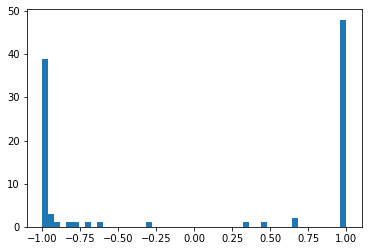

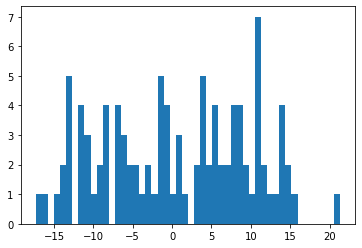

In [27]:
# Many h values go to extremes, -1 +1 due to tanh
h = torch.tanh(WORD_EMBEDDINGS.view(-1,EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1)
plt.hist(h.tolist(), 50);
plt.figure()
plt.hist((WORD_EMBEDDINGS.view(-1,EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1).tolist(), 50);

In [41]:
# Adjust weights by gain, manually

W1 = torch.randn((EMBEDDING_DIMENSION * BLOCK_SIZE, HIDDEN_LAYER_NEURONS)) * ((5/3) / (EMBEDDING_DIMENSION * BLOCK_SIZE)**0.5)
b1 = torch.randn(HIDDEN_LAYER_NEURONS) * 0.01
W2 = torch.randn((HIDDEN_LAYER_NEURONS, VOCABULARY_SIZE)) * ((5/3) / HIDDEN_LAYER_NEURONS**0.5)
b2 = torch.randn(VOCABULARY_SIZE) * 0.01

parameters = [CHAR_EMBEDDINGS, W1, W2, b1, b2]
# Many h values go to extremes, -1 +1 due to tanh


In [44]:
# Do BatchNorm, instead
pre_activation = WORD_EMBEDDINGS.view(-1,EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1

# make it gaussian, subtract mean and divide by STD
pre_activation = pre_activation - pre_activation.mean(0, keepdim=True) / pre_activation.std(0, keepdim=True)
h = torch.tanh(pre_activation)



In [46]:
# Batchnorm with gains and shift offsets
bngains = torch.ones((1, HIDDEN_LAYER_NEURONS))
bnoffsets = torch.zeros((1, HIDDEN_LAYER_NEURONS))
pre_activation = WORD_EMBEDDINGS.view(-1,EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1

pre_activation = bngains * \ 
    (pre_activation - pre_activation.mean(0, keepdim=True) / pre_activation.std(0, keepdim=True)) \
    + bnoffsets
h = torch.tanh(pre_activation)

parameters = [CHAR_EMBEDDINGS, W1, W2, b1, b2, bngains, bnoffsets]

In [ ]:
# Batch Mean, Std over entire training set

pre_activation = WORD_EMBEDDINGS.view(-1,EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1 + b1

with torch.no_grad():
    bnmean_all = pre_activation.mean(0, keepdim=True) 
    bnstd_all = pre_activation.std(0, keepdim=True)

pre_activation = bngains * (pre_activation - bnmean_all / bnstd_all) + bnoffsets
h = torch.tanh(pre_activation)

# Use them in mini-batches until next layer

In [50]:
# Running bnmean_all and bnstd_all
bnmean_running = torch.zeros((1, HIDDEN_LAYER_NEURONS))
bnstd_running = torch.ones((1, HIDDEN_LAYER_NEURONS))


# TRAINING LOOP
bnmeani = pre_activation.mean(0, keepdim=True)
bnstdi = pre_activation.std(0, keepdim=True)
   
pre_activation = bngains * (pre_activation - bnmean_running) / bnstd_running + bnoffsets

with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
# TRAINING LOOP

In [55]:
# We can ignore bias if we are BatchNorming after the h calculation.


# W1 = torch.randn((EMBEDDING_DIMENSION * BLOCK_SIZE, HIDDEN_LAYER_NEURONS)) * ((5/3) / (EMBEDDING_DIMENSION * BLOCK_SIZE)**0.5)
# # b1 = torch.randn(HIDDEN_LAYER_NEURONS) * 0.01
# W2 = torch.randn((HIDDEN_LAYER_NEURONS, VOCABULARY_SIZE)) * ((5/3) / HIDDEN_LAYER_NEURONS**0.5)
# b2 = torch.randn(VOCABULARY_SIZE) * 0.01

# bngains = torch.ones((1, HIDDEN_LAYER_NEURONS))
# bnoffsets = torch.zeros((1, HIDDEN_LAYER_NEURONS))

# bnmean_running = torch.zeros((1, HIDDEN_LAYER_NEURONS))
# bnstd_running = torch.ones((1, HIDDEN_LAYER_NEURONS))

# parameters = [CHAR_EMBEDDINGS, W1, W2, b2, bngains, bnoffsets]

# losses = []

STEP_SIZE = 200000
BATCH_SIZE = 32

# Step size vs Epoch

for step in range(STEP_SIZE):

    for p in parameters:
        p.requires_grad = True
        
    batch_idx = torch.randint(0, inputs.shape[0], (BATCH_SIZE,))

    WORD_EMBEDDINGS = CHAR_EMBEDDINGS[inputs[batch_idx]]
    pre_activation = WORD_EMBEDDINGS.view(-1,EMBEDDING_DIMENSION * BLOCK_SIZE) @ W1
    
    bnmeani = pre_activation.mean(0, keepdim=True)
    bnstdi = pre_activation.std(0, keepdim=True)
    
    pre_activation = bngains * (pre_activation - bnmean_running) / bnstd_running + bnoffsets

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(pre_activation) #+ b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, labels[batch_idx])
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if step < 100000 else 0.01 # step learning rate decay
    
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())


2.134913444519043
